# Simulations

This notebook contains code that would allow the reproduction of the simulation results in the paper. Requirement for the code can be found below

- Julia v1.6.2 with the following default packages
   1. LinearAlgebra
   2. Statistics

- External Packages
    1. [CSV](https://csv.juliadata.org/stable/) v0.8.5
    2. [DataFrames](https://dataframes.juliadata.org/stable/) v1.2.2 
    3. [Distributions](https://juliastats.org/Distributions.jl/stable) v0.24.18
    4. [Optim](https://julianlsolvers.github.io/Optim.jl/stable/) v1.4.1
    5. [Kronecker](https://github.com/MichielStock/Kronecker.jl) v0.4.4
    6. [Plots](http://docs.juliaplots.org/latest/) v1.20.0
    7. [LaTeXStrings](https://github.com/stevengj/LaTeXStrings.jl) v1.2.1
    8. [Mat](https://github.com/JuliaIO/MAT.jl)
 

### Necessary packages

In [1]:
using LinearAlgebra
using MAT
using Distributions
using Kronecker
using Optim
using Statistics
using CSV
using DataFrames
using Plots
using LaTeXStrings

### Setting up parameters of the simulation

In [ ]:
p = 5; #number of forecasters.
df = 3;#Degrees of freedom for t-distribution.
R = 5000;#number of replications
N = [20,30,50,100,200,300,400,500,600,700,800,900,1000];#sample size [20,30,50]

## Set 1: positive weights only

#### Skewness parameter

$$ b = \left(
\begin{array} \\
           1.5 \\
           -1 \\
           1.2 \\
           -1.8 \\
            1.9
\end{array} 
\right) $$

#### Random Var-Cov matrix

$$ \Sigma = \left( \begin{array} \\ 6.155 & -1.509 & 3.340 & -4.405& -3.877\\
 -1.509 & 10.493 & -3.311 & 2.470 & -0.985\\
3.340 & -3.311 & 7.772 & -1.097 & -2.955\\
-4.405 & 2.470 & -1.097 & 11.132 & 4.001\\
-3.877 & -0.985 & -2.955 & 4.001 & 8.609
\end{array} \right) $$

#### Optimal (true) weights 

$$ a = \left(\begin{array} \\
           0.2899 \\
           0.1930 \\
           0.1822 \\
           0.0794 \\
           0.2554 \end{array} \right) $$

### Loading Set 1 random var-cov matrix and skewness parameters

In [ ]:
Set1 = matread("SN_Set1.mat")
b1 = Set1["b"]
Sigma1 = Set1["Sigma"]
display(Sigma1)
display(b1)

## Set 2: Mix of positive and negative weights

#### Skewness parameter

$$ b = \left(\begin{array} \\
           -1 \\
           -0.8 \\
           0.2 \\
           -0.4 \\
            0.7
         \end{array} \right) $$

#### Random Var-Cov matrix

$$ \Sigma = \left( \begin{array} \\ 6.109 & 3.178& -0.994 &1.408& 2.158\\
3.178 & 7.628 & 3.700 & -2.819 & 1.318\\
-0.994 & 3.700 & 3.514 & -3.399 & 0.191\\
1.408 & -2.819 & -3.399 & 4.589 & 0.785\\
2.158 & 1.318 & 0.191 & 0.785 & 3.398
\end{array} \right) $$

#### Optimal (true) weights

$$ a = \left(\begin{array} \\
           0.2592 \\
           -0.31073 \\
           0.80548 \\
           0.3738 \\
            -0.1278
        \end{array} \right) $$

### Loading Set 2 random var-cov matrix and skewness parameters

In [ ]:
Set2 = matread("SN_Set2.mat") 
b2 = Set2["b"]
Sigma2 = Set2["Sigma"]
display(Sigma2)
display(b2)

### Set 1 | Set 2: the optimal [true] weights 

In [ ]:
#Generate Skew Normal Random Variable. 
#Set 1
Lambda1 = b1.*Matrix{Float64}(I, size(b1,1), size(b1,1))
Omega1 = Sigma1 + (1-2/pi)*(Lambda1*Lambda1')
atheory1 = Omega1\ones(p,1)/(ones(p,1)'/Omega1*ones(p,1)); 
display("Optimal true weights set 1:")
display(atheory1)
#Set 2
Lambda2 = b2.*Matrix{Float64}(I, size(b2,1), size(b2,1))
Omega2 = Sigma2 + (1-2/pi)*(Lambda2*Lambda2')
atheory2 = Omega2\ones(p,1)/(ones(p,1)'/Omega2*ones(p,1));
display("Optimal true weights set 2:")
display(atheory2)

## Simulations

#### MAE LOSS FUNCTION

In [ ]:
function maeloss(a_init,nu_it)
    (T,p) = size(nu_it)
    a = zeros(p,1)
    a[1:p-1,1] = a_init
    a[p,1] = 1 - sum(a_init)
    nu_c = nu_it*a
    mae = sum(abs.(nu_c))./T
    return mae
end

#### SIMULATIONS FUNCTION

In [ ]:
function simulations(atheory,Sigma,Lambda,R,N)
    asn_MSE = zeros(length(atheory),R,length(N));
    asn_MAE = zeros(length(atheory),R,length(N));
    at3_MSE = zeros(length(atheory),R,length(N));
    at3_MAE = zeros(length(atheory),R,length(N));
    for i = 1:length(N)
        Ni = N[i,1]
        
        for r = 1:R
        # Skew Random Forecast Errors
            U = rand(MvNormal(Sigma), Ni)
            tau = rand(MvNormal(Matrix{Float64}(I,p,p)),Ni)

            Xi = -sqrt(2/pi)*Lambda*ones(p,1)
            Z = kronecker(Xi',ones(Ni,1)) + broadcast(abs,tau')*Lambda+U'
        
        #MSE weights
            Omegahat_SN = (Z'*Z)/Ni
            asn_MSE[:,r,i] = Omegahat_SN\ones(p,1)/(ones(p,1)'/Omegahat_SN*ones(p,1))
            #display(asn_MSE)
        #MAE weights
            asn_init = Omegahat_SN\ones(p,1)/(ones(p,1)'/Omegahat_SN*ones(p,1))
            sln_sn = optimize(asn_mae->maeloss(asn_mae, Z), asn_init[1:p-1,1],BFGS()) 
            asn_mae_raw = Optim.minimizer(sln_sn)
            asn_MAE[:,r,i] = [asn_mae_raw;1-sum(asn_mae_raw)]
        
        ## t_3 forecast errors
            E = rand(MvTDist(df,zeros(p),Omega),20)'
        
        #MSE weights
            Omegahat_t3 = (E'*E)/Ni;
            at3_MSE[:,r,i] = Omegahat_t3\ones(p,1)/(ones(p,1)'/Omegahat_t3*ones(p,1))
        
        #MAE weights
            at3_init = Omegahat_t3\ones(p,1)/(ones(p,1)'/Omegahat_t3*ones(p,1))
            sln_t3 = optimize(at3_mae->maeloss(at3_mae, Z), at3_init[1:p-1,1],BFGS()) 
            at3_mae_raw = Optim.minimizer(sln_t3)
            at3_MAE[:,r,i] = [at3_mae_raw;1-sum(at3_mae_raw)];
            #display(at3_MAE)
        end
    end
    display("Simulations are done")
    return asn_MSE, asn_MAE, at3_MSE, at3_MAE
end


In [ ]:
(asn_MSE1, asn_MAE1, at3_MSE1, at3_MAE1) = simulations(atheory1,Sigma1,Lambda1,R,N)
(asn_MSE2, asn_MAE2, at3_MSE2, at3_MAE2) = simulations(atheory2,Sigma2,Lambda2,R,N);

### Gathering simulated results and weights

In [1]:
dropmean(A; dims=:) = dropdims(mean(A; dims=dims); dims=dims) 

dropmean (generic function with 1 method)

In [2]:
dropstd(A; dims=:) = dropdims(std(A; dims=dims); dims=dims) 

dropstd (generic function with 1 method)

In [ ]:
amean_sn_diff1 = dropmean(asn_MSE1-asn_MAE1, dims=2)'
adev_sn_diff1 = dropstd(asn_MSE1-asn_MAE1,dims=2)'
amean_t3_diff1 = dropmean(at3_MSE1-at3_MAE1, dims=2)'
adev_t3_diff1 = dropstd(at3_MSE1-at3_MAE1,dims=2)'

amean_sn_diff2 = dropmean(asn_MSE2-asn_MAE2, dims=2)'
adev_sn_diff2 = dropstd(asn_MSE2-asn_MAE2,dims=2)'
amean_t3_diff2 = dropmean(at3_MSE2-at3_MAE2, dims=2)'
adev_t3_diff2 = dropstd(at3_MSE2-at3_MAE2,dims=2)';

In [ ]:
Data_sn1 = hcat(N, amean_sn_diff1,adev_sn_diff1)
Data_sn2 = hcat(N, amean_sn_diff2,adev_sn_diff2)
Data_t1 = hcat(N, amean_t3_diff1,adev_t3_diff1)
Data_t2 = hcat(N, amean_t3_diff2,adev_t3_diff2);

## Results: Figures 2 - 5 and Online Appendix Figures 1 - 4

**Notes**: 
* The simulation results with which were used to construct the figures in the paper and in the Online Supplement are stored in the four .csv files in this folder. 
* These results are used here below to replicate exactly the figures shown in the paper.  
* There may be variations in the results because of differences in the random number generator and the solver (optimizer) in the two software.

In [2]:
Data_sn1 = DataFrame(CSV.File("sim_snSet1.csv"))
Data_sn2 = DataFrame(CSV.File("sim_snSet2.csv"))
Data_t1 = DataFrame(CSV.File("sim_t3Set1.csv"))
Data_t2 = DataFrame(CSV.File("sim_t3Set2.csv"))

,Var1,Var2_1,Var2_2,Var2_3,Var2_4,Var2_5,adev_t3_1
,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,20,-0.000730386,-0.000768713,9.13105e-5,0.000549545,0.000858244,0.036641
2,30,-0.000713181,0.000729849,-0.000170792,-6.89213e-5,0.000223045,0.0405533
3,50,-0.000253789,0.000393784,-8.53034e-5,0.000222787,-0.000277478,0.0404495
4,100,-0.000118564,0.000515682,-0.000624471,-0.000434508,0.000661861,0.0413101
5,200,-0.000282974,6.99966e-5,-9.1698e-5,0.000627492,-0.000322817,0.0378123
6,300,0.000817915,-0.000377225,-0.000161954,-0.000486367,0.000207631,0.0356155
7,400,-0.000454749,4.70344e-5,-0.000236991,0.000421008,0.000223697,0.0342922
8,500,6.34802e-5,-0.000423355,-1.06924e-5,0.000180046,0.000190521,0.0315074
9,600,0.000148033,-0.000707897,0.000787699,8.18977e-5,-0.000309733,0.0318873


### Skew normal (Set 1)

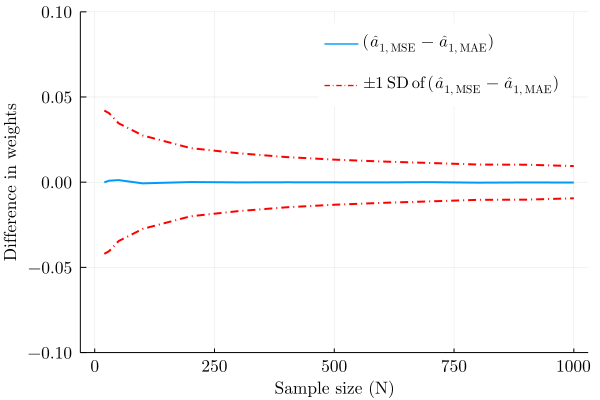

In [3]:
plot(Data_sn1[:,1], Data_sn1[:,2],labels= L"$(\hat{a}_{\textrm{1,MSE}}-\hat{a}_{\textrm{1,MAE}})$", xtickfont=font("Computer Modern",11),ytickfont=font("Computer Modern",11),legend=:topright,fg_legend = :transparent, ylims=(-0.1,0.1),linewidth = [2 1 1], legendfont = font("Computer Modern",11))
scatter!([minimum(Data_sn1[:,2])],[0], label=" ", ms=0, mc=:white, msc=:white)
plot!(Data_sn1[:,1], Data_sn1[:,7],labels= L"$\pm 1 \textrm{\: SD \: of } \; (\hat{a}_{\textrm{1,MSE}}-\hat{a}_{\textrm{1,MAE}})$",style=:dashdot, color=:red, linewidth = [2 1 1])
plot!(Data_sn1[:,1], -Data_sn1[:,7],labels = false,style=:dashdot, color=:red, linewidth = [2 1 1])
xaxis!("Sample size (N)", font("Computer Modern",11))
yaxis!("Difference in weights", font("Computer Modern",11))
#savefig(figure, "figure_a1sn1.pdf")

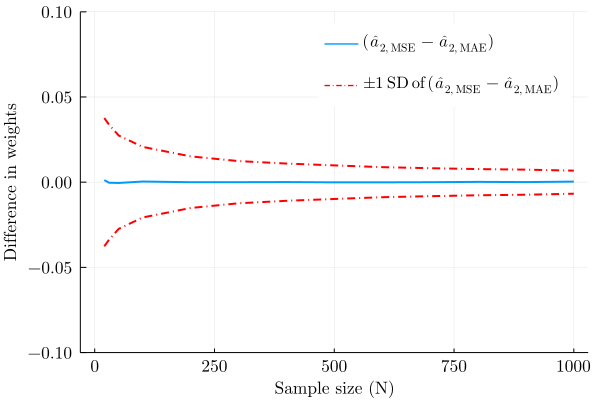

In [4]:
plot(Data_sn1[:,1], Data_sn1[:,3],labels= L"$(\hat{a}_{\textrm{2,MSE}}-\hat{a}_{\textrm{2,MAE}})$", xtickfont=font("Computer Modern",11),ytickfont=font("Computer Modern",11),legend=:topright,fg_legend = :transparent, ylims=(-0.1,0.1),linewidth = [2 1 1], legendfont = font(11))
scatter!([minimum(Data_sn1[:,3])],[0], label=" ", ms=0, mc=:white, msc=:white)
plot!(Data_sn1[:,1], Data_sn1[:,8],labels= L"$\pm 1 \textrm{\: SD \: of } \; (\hat{a}_{\textrm{2,MSE}}-\hat{a}_{\textrm{2,MAE}})$",style=:dashdot, color=:red, linewidth = [2 1 1])
figure = plot!(Data_sn1[:,1], -Data_sn1[:,8],labels = false,style=:dashdot, color=:red, linewidth = [2 1 1])
xaxis!("Sample size (N)", font("Computer Modern",11))
yaxis!("Difference in weights", font("Computer Modern",11))
#savefig(figure, "figure_a2sn1.pdf")

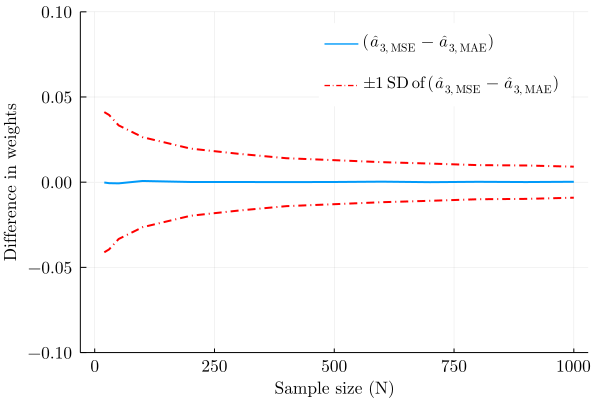

In [5]:
plot(Data_sn1[:,1], Data_sn1[:,4],labels= L"$(\hat{a}_{\textrm{3,MSE}}-\hat{a}_{\textrm{3,MAE}})$", xtickfont=font("Computer Modern",11),ytickfont=font("Computer Modern",11),legend=:topright,fg_legend = :transparent, ylims=(-0.1,0.1),linewidth = [2 1 1], legendfont = font(11))
scatter!([minimum(Data_sn1[:,4])],[0], label=" ", ms=0, mc=:white, msc=:white)
plot!(Data_sn1[:,1], Data_sn1[:,9],labels= L"$\pm 1 \textrm{\: SD \: of } \; (\hat{a}_{\textrm{3,MSE}}-\hat{a}_{\textrm{3,MAE}})$",style=:dashdot, color=:red, linewidth = [2 1 1])
figure = plot!(Data_sn1[:,1], -Data_sn1[:,9],labels = false,style=:dashdot, color=:red, linewidth = [2 1 1])
xaxis!("Sample size (N)", font("Computer Modern",11))
yaxis!("Difference in weights", font("Computer Modern",11))
#savefig(figure, "figure_a3sn1.pdf")

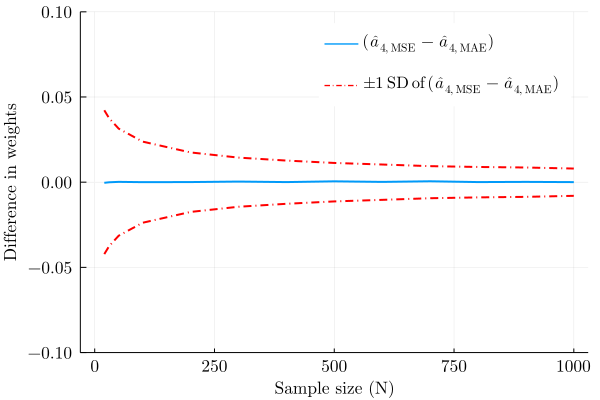

In [6]:
plot(Data_sn1[:,1], Data_sn1[:,5],labels= L"$(\hat{a}_{\textrm{4,MSE}}-\hat{a}_{\textrm{4,MAE}})$", xtickfont=font("Computer Modern",11),ytickfont=font("Computer Modern",11),legend=:topright,fg_legend = :transparent, ylims=(-0.1,0.1),linewidth = [2 1 1], legendfont = font(11))
scatter!([minimum(Data_sn1[:,5])],[0], label=" ", ms=0, mc=:white, msc=:white)
plot!(Data_sn1[:,1], Data_sn1[:,10],labels= L"$\pm 1 \textrm{\: SD \: of } \; (\hat{a}_{\textrm{4,MSE}}-\hat{a}_{\textrm{4,MAE}})$",style=:dashdot, color=:red, linewidth = [2 1 1])
figure = plot!(Data_sn1[:,1], -Data_sn1[:,10],labels = false,style=:dashdot, color=:red, linewidth = [2 1 1])
xaxis!("Sample size (N)", font("Computer Modern",11))
yaxis!("Difference in weights", font("Computer Modern",11))
#savefig(figure, "figure_a4sn1.pdf")

### Skew normal (Set 2)

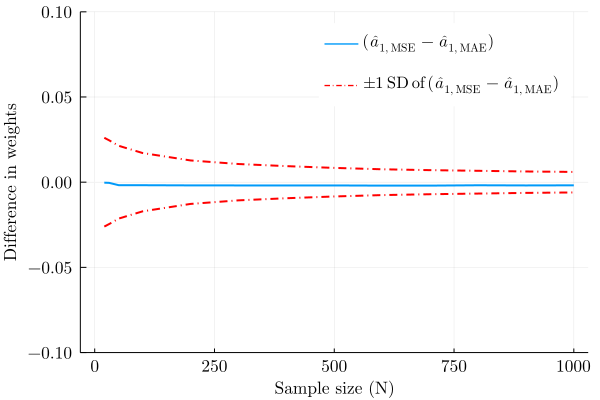

In [7]:
plot(Data_sn2[:,1], Data_sn2[:,2],labels= L"$(\hat{a}_{\textrm{1,MSE}}-\hat{a}_{\textrm{1,MAE}})$", xtickfont=font("Computer Modern",11),ytickfont=font("Computer Modern",11),legend=:topright,fg_legend = :transparent, ylims=(-0.1,0.1),linewidth = [2 1 1], legendfont = font(11))
scatter!([minimum(Data_sn2[:,2])],[0], label=" ", ms=0, mc=:white, msc=:white)
plot!(Data_sn2[:,1], Data_sn2[:,7],labels= L"$\pm 1 \textrm{\: SD \: of }  \; (\hat{a}_{\textrm{1,MSE}}-\hat{a}_{\textrm{1,MAE}})$",style=:dashdot, color=:red, linewidth = [2 1 1])
figure = plot!(Data_sn2[:,1], -Data_sn2[:,7],labels = false,style=:dashdot, color=:red, linewidth = [2 1 1])
xaxis!("Sample size (N)", font("Computer Modern",11))
yaxis!("Difference in weights", font("Computer Modern",11))
#savefig(figure, "figure_a1sn2.pdf")

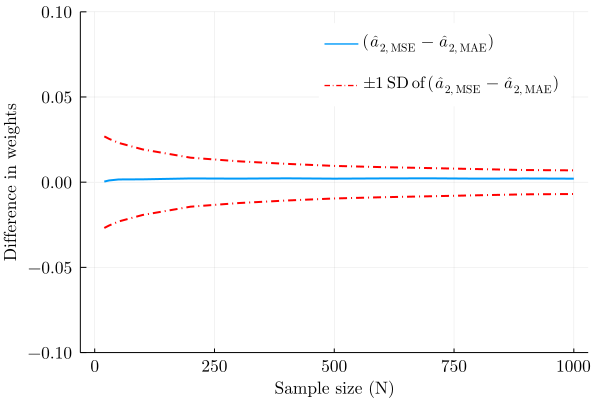

In [8]:
plot(Data_sn2[:,1], Data_sn2[:,3],labels= L"$(\hat{a}_{\textrm{2,MSE}}-\hat{a}_{\textrm{2,MAE}})$", xtickfont=font("Computer Modern",11),ytickfont=font("Computer Modern",11),legend=:topright,fg_legend = :transparent, ylims=(-0.1,0.1),linewidth = [2 1 1], legendfont = font(11))
scatter!([minimum(Data_sn2[:,3])],[0], label=" ", ms=0, mc=:white, msc=:white)
plot!(Data_sn2[:,1], Data_sn2[:,8],labels= L"$\pm 1 \textrm{\: SD \: of }  \; (\hat{a}_{\textrm{2,MSE}}-\hat{a}_{\textrm{2,MAE}})$",style=:dashdot, color=:red, linewidth = [2 1 1])
figure = plot!(Data_sn2[:,1], -Data_sn2[:,8],labels = false,style=:dashdot, color=:red, linewidth = [2 1 1])
xaxis!("Sample size (N)", font("Computer Modern",11))
yaxis!("Difference in weights", font("Computer Modern",11))
#savefig(figure, "figure_a2sn2.pdf")

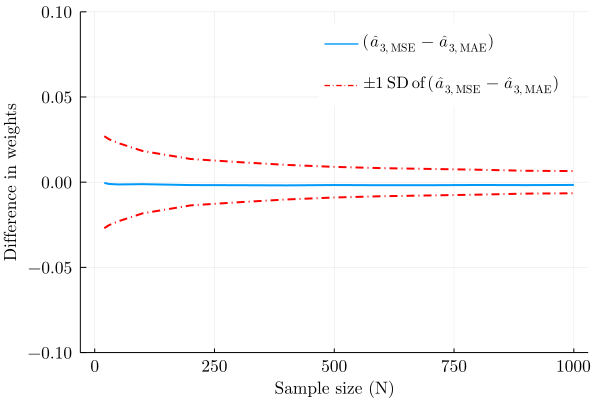

In [9]:
plot(Data_sn2[:,1], Data_sn2[:,4],labels= L"$(\hat{a}_{\textrm{3,MSE}}-\hat{a}_{\textrm{3,MAE}})$", xtickfont=font("Computer Modern",11),ytickfont=font("Computer Modern",11),legend=:topright,fg_legend = :transparent, ylims=(-0.1,0.1),linewidth = [2 1 1], legendfont = font(11))
scatter!([minimum(Data_sn2[:,4])],[0], label=" ", ms=0, mc=:white, msc=:white)
plot!(Data_sn2[:,1], Data_sn2[:,9],labels= L"$\pm 1 \textrm{\: SD \: of }  \; (\hat{a}_{\textrm{3,MSE}}-\hat{a}_{\textrm{3,MAE}})$",style=:dashdot, color=:red, linewidth = [2 1 1])
figure = plot!(Data_sn2[:,1], -Data_sn2[:,9],labels = false,style=:dashdot, color=:red, linewidth = [2 1 1])
xaxis!("Sample size (N)", font("Computer Modern",11))
yaxis!("Difference in weights", font("Computer Modern",11))
#savefig(figure, "figure_a3sn2.pdf")

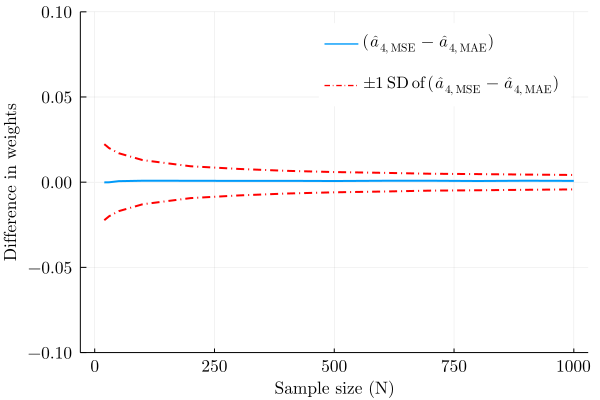

In [10]:
plot(Data_sn2[:,1], Data_sn2[:,5],labels= L"$(\hat{a}_{\textrm{4,MSE}}-\hat{a}_{\textrm{4,MAE}})$", xtickfont=font("Computer Modern",11),ytickfont=font("Computer Modern",11),legend=:topright,fg_legend = :transparent, ylims=(-0.1,0.1),linewidth = [2 1 1], legendfont = font(11))
scatter!([minimum(Data_sn2[:,5])],[0], label=" ", ms=0, mc=:white, msc=:white)
plot!(Data_sn2[:,1], Data_sn2[:,10],labels= L"$\pm 1 \textrm{\: SD \: of }  \; (\hat{a}_{\textrm{4,MSE}}-\hat{a}_{\textrm{4,MAE}})$",style=:dashdot, color=:red, linewidth = [2 1 1])
figure = plot!(Data_sn2[:,1], -Data_sn2[:,10],labels = false,style=:dashdot, color=:red, linewidth = [2 1 1])
xaxis!("Sample size (N)", font("Computer Modern",11))
yaxis!("Difference in weights", font("Computer Modern",11))
#savefig(figure, "figure_a4sn2.pdf")

### T3 Distribution (Set 1)

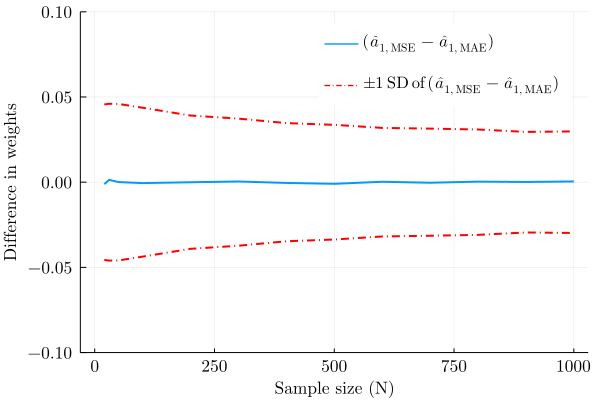

In [11]:
plot(Data_t1[:,1], Data_t1[:,2],labels= L"$(\hat{a}_{\textrm{1,MSE}}-\hat{a}_{\textrm{1,MAE}})$", xtickfont=font("Computer Modern",11),ytickfont=font("Computer Modern",11),legend=:topright,fg_legend = :transparent, ylims=(-0.1,0.1),linewidth = [2 1 1], legendfont = font(11))
scatter!([minimum(Data_t1[:,2])],[0], label=" ", ms=0, mc=:white, msc=:white)
plot!(Data_t1[:,1], Data_t1[:,7],labels= L"$\pm 1 \textrm{\: SD \: of } \; (\hat{a}_{\textrm{1,MSE}}-\hat{a}_{\textrm{1,MAE}})$",style=:dashdot, color=:red, linewidth = [2 1 1])
figure = plot!(Data_t1[:,1], -Data_t1[:,7],labels = false,style=:dashdot, color=:red, linewidth = [2 1 1])
xaxis!("Sample size (N)", font("Computer Modern",11))
yaxis!("Difference in weights", font("Computer Modern",11))
#savefig(figure, "figure_a1t1.pdf")

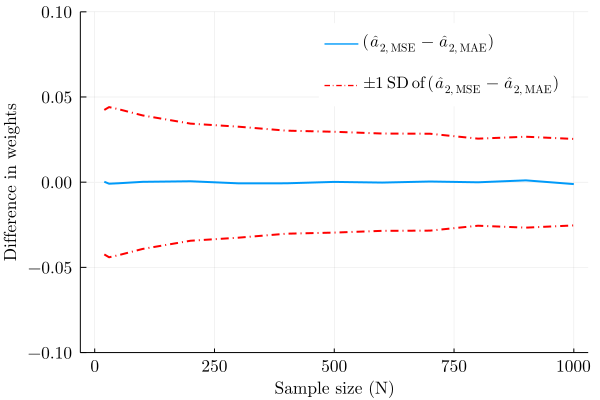

In [12]:
plot(Data_t1[:,1], Data_t1[:,3],labels= L"$(\hat{a}_{\textrm{2,MSE}}-\hat{a}_{\textrm{2,MAE}})$", xtickfont=font("Computer Modern",11),ytickfont=font("Computer Modern",11),legend=:topright,fg_legend = :transparent, ylims=(-0.1,0.1),linewidth = [2 1 1], legendfont = font(11))
scatter!([minimum(Data_t1[:,3])],[0], label=" ", ms=0, mc=:white, msc=:white)
plot!(Data_t1[:,1], Data_t1[:,8],labels= L"$\pm 1 \textrm{\: SD \: of }\; (\hat{a}_{\textrm{2,MSE}}-\hat{a}_{\textrm{2,MAE}})$",style=:dashdot, color=:red, linewidth = [2 1 1])
figure = plot!(Data_t1[:,1], -Data_t1[:,8],labels = false,style=:dashdot, color=:red, linewidth = [2 1 1])
xaxis!("Sample size (N)", font("Computer Modern",11))
yaxis!("Difference in weights", font("Computer Modern",11))
#savefig(figure, "figure_a2t1.pdf")

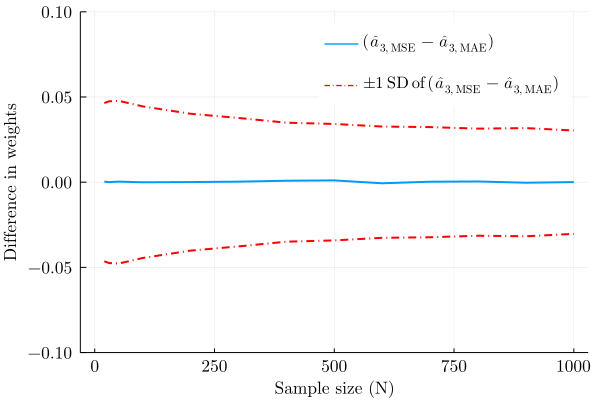

In [13]:
plot(Data_t1[:,1], Data_t1[:,4],labels= L"$(\hat{a}_{\textrm{3,MSE}}-\hat{a}_{\textrm{3,MAE}})$", xtickfont=font("Computer Modern",11),ytickfont=font("Computer Modern",11),legend=:topright,fg_legend = :transparent, ylims=(-0.1,0.1),linewidth = [2 1 1], legendfont = font(11))
scatter!([minimum(Data_t1[:,4])],[0], label=" ", ms=0, mc=:white, msc=:white)
plot!(Data_t1[:,1], Data_t1[:,9],labels= L"$\pm 1 \textrm{\: SD \: of } \; (\hat{a}_{\textrm{3,MSE}}-\hat{a}_{\textrm{3,MAE}})$",style=:dashdot, color=:red, linewidth = [2 1 1])
figure = plot!(Data_t1[:,1], -Data_t1[:,9],labels = false,style=:dashdot, color=:red, linewidth = [2 1 1])
xaxis!("Sample size (N)", font("Computer Modern",11))
yaxis!("Difference in weights", font("Computer Modern",11))
#savefig(figure, "figure_a3t1.pdf")

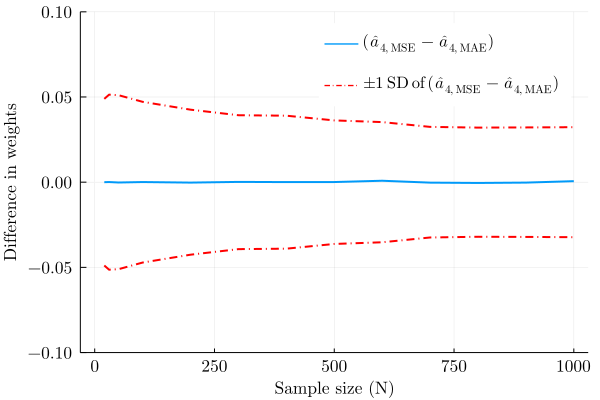

In [14]:
plot(Data_t1[:,1], Data_t1[:,5],labels= L"$(\hat{a}_{\textrm{4,MSE}}-\hat{a}_{\textrm{4,MAE}})$", xtickfont=font("Computer Modern",11),ytickfont=font("Computer Modern",11),legend=:topright,fg_legend = :transparent, ylims=(-0.1,0.1),linewidth = [2 1 1], legendfont = font(11))
scatter!([minimum(Data_t1[:,5])],[0], label=" ", ms=0, mc=:white, msc=:white)
plot!(Data_t1[:,1], Data_t1[:,10],labels= L"$\pm 1 \textrm{\: SD \: of } \; (\hat{a}_{\textrm{4,MSE}}-\hat{a}_{\textrm{4,MAE}})$",style=:dashdot, color=:red, linewidth = [2 1 1])
figure = plot!(Data_t1[:,1], -Data_t1[:,10],labels = false,style=:dashdot, color=:red, linewidth = [2 1 1])
xaxis!("Sample size (N)", font("Computer Modern",11))
yaxis!("Difference in weights", font("Computer Modern",11))
#savefig(figure, "figure_a4t1.pdf")

### T3 Distribution (Set 2)

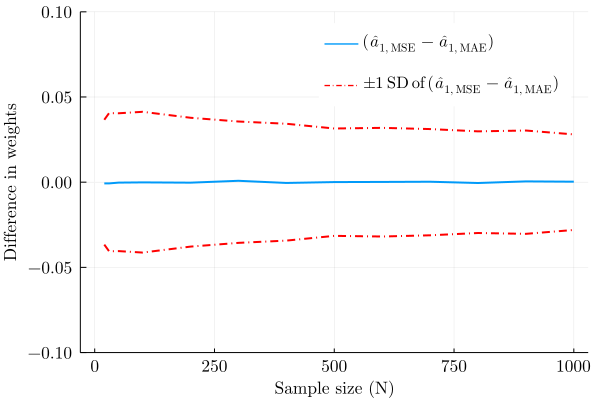

In [15]:
plot(Data_t2[:,1], Data_t2[:,2],labels= L"$(\hat{a}_{\textrm{1,MSE}}-\hat{a}_{\textrm{1,MAE}})$", xtickfont=font("Computer Modern",11),ytickfont=font("Computer Modern",11),legend=:topright,fg_legend = :transparent, ylims=(-0.1,0.1),linewidth = [2 1 1], legendfont = font(11))
scatter!([minimum(Data_t2[:,2])],[0], label=" ", ms=0, mc=:white, msc=:white)
plot!(Data_t2[:,1], Data_t2[:,7],labels= L"$\pm 1 \textrm{\: SD \: of } \; (\hat{a}_{\textrm{1,MSE}}-\hat{a}_{\textrm{1,MAE}})$",style=:dashdot, color=:red, linewidth = [2 1 1])
figure = plot!(Data_t2[:,1], -Data_t2[:,7],labels = false,style=:dashdot, color=:red, linewidth = [2 1 1])
xaxis!("Sample size (N)", font("Computer Modern",11))
yaxis!("Difference in weights", font("Computer Modern",11))
#savefig(figure, "figure_a1t2.pdf")

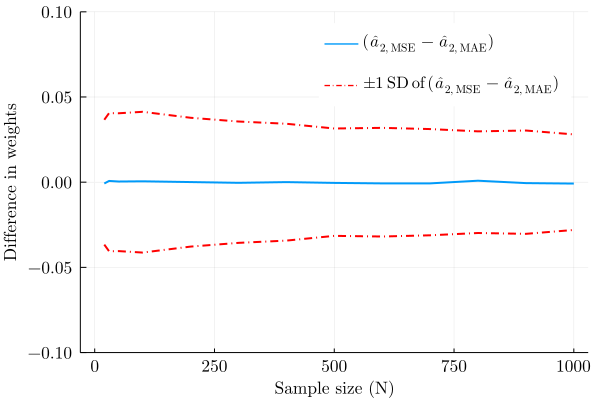

In [16]:
plot(Data_t2[:,1], Data_t2[:,3],labels= L"$(\hat{a}_{\textrm{2,MSE}}-\hat{a}_{\textrm{2,MAE}})$", xtickfont=font("Computer Modern",11),ytickfont=font("Computer Modern",11),legend=:topright,fg_legend = :transparent, ylims=(-0.1,0.1),linewidth = [2 1 1], legendfont = font(11))
scatter!([minimum(Data_t2[:,3])],[0], label=" ", ms=0, mc=:white, msc=:white)
plot!(Data_t2[:,1], Data_t2[:,7],labels= L"$\pm 1 \textrm{\: SD \: of } \; (\hat{a}_{\textrm{2,MSE}}-\hat{a}_{\textrm{2,MAE}})$",style=:dashdot, color=:red, linewidth = [2 1 1])
figure = plot!(Data_t2[:,1], -Data_t2[:,7],labels = false,style=:dashdot, color=:red, linewidth = [2 1 1])
xaxis!("Sample size (N)", font("Computer Modern",11))
yaxis!("Difference in weights", font("Computer Modern",11))
#savefig(figure, "figure_a2t2.pdf")

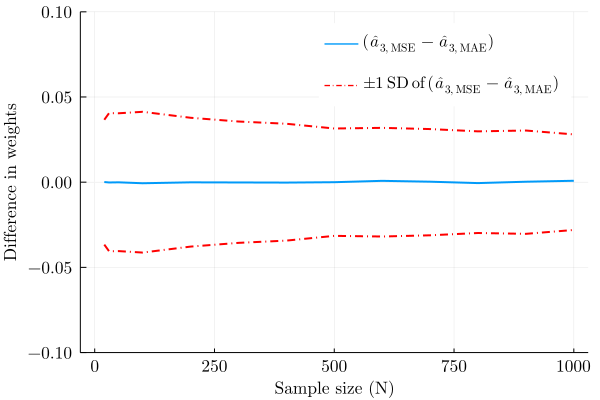

In [17]:
plot(Data_t2[:,1], Data_t2[:,4],labels= L"$(\hat{a}_{\textrm{3,MSE}}-\hat{a}_{\textrm{3,MAE}})$", xtickfont=font("Computer Modern",11),ytickfont=font("Computer Modern",11),legend=:topright,fg_legend = :transparent, ylims=(-0.1,0.1),linewidth = [2 1 1], legendfont = font(11))
scatter!([minimum(Data_t2[:,4])],[0], label=" ", ms=0, mc=:white, msc=:white)
plot!(Data_t2[:,1], Data_t2[:,7],labels= L"$\pm 1 \textrm{\: SD \: of } \; (\hat{a}_{\textrm{3,MSE}}-\hat{a}_{\textrm{3,MAE}})$",style=:dashdot, color=:red, linewidth = [2 1 1])
figure = plot!(Data_t2[:,1], -Data_t2[:,7],labels = false,style=:dashdot, color=:red, linewidth = [2 1 1])
xaxis!("Sample size (N)", font("Computer Modern",11))
yaxis!("Difference in weights", font("Computer Modern",11))
#savefig(figure, "figure_a3t2.pdf")

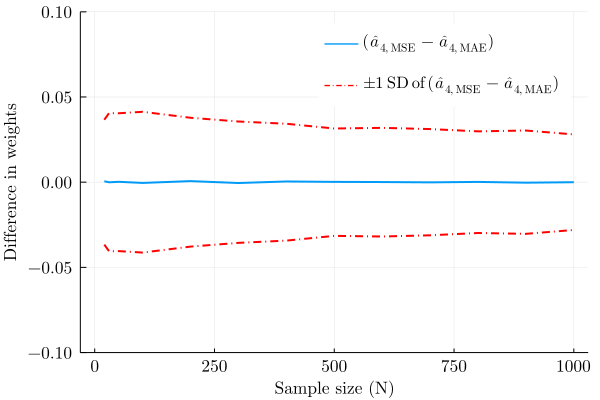

In [18]:
plot(Data_t2[:,1], Data_t2[:,5],labels= L"$(\hat{a}_{\textrm{4,MSE}}-\hat{a}_{\textrm{4,MAE}})$", xtickfont=font("Computer Modern",11),ytickfont=font("Computer Modern",11),legend=:topright,fg_legend = :transparent, ylims=(-0.1,0.1),linewidth = [2 1 1], legendfont = font(11))
scatter!([minimum(Data_t2[:,5])],[0], label=" ", ms=0, mc=:white, msc=:white)
plot!(Data_t2[:,1], Data_t2[:,7],labels= L"$\pm 1 \textrm{\: SD \: of } \; (\hat{a}_{\textrm{4,MSE}}-\hat{a}_{\textrm{4,MAE}})$",style=:dashdot, color=:red, linewidth = [2 1 1])
figure = plot!(Data_t2[:,1], -Data_t2[:,7],labels = false,style=:dashdot, color=:red, linewidth = [2 1 1])
xaxis!("Sample size (N)", font("Computer Modern",11))
yaxis!("Difference in weights", font("Computer Modern",11))
#savefig(figure, "figure_a4t2.pdf")